# Generative Adversarial Networks (GANs) for Monet-style Image Generation

In this project, I explore Generative Adversarial Networks (GANs), a type of artificial intelligence model that is capable of generating new data that resembles the input data. The challenge is to create a GAN that can generate images in the style of Claude Monet. This involves training two neural networks - a generator and a discriminator - to work against each other. The generator's goal is to create images so convincing that the discriminator, which is trained to distinguish between real and generated images, is fooled into believing the generated images are real.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

ARTIFACT_DIR = "./artifact/"
IMG_DIR = './data/monet_jpg/'
IMG_FILES = os.listdir(IMG_DIR)
print(f"Discovered {len(IMG_FILES)} images in 'monet_jpg'")


def save_plot(filename: str) -> None:
    out_path = os.path.join(ARTIFACT_DIR, os.path.basename(filename))
    plt.savefig(out_path, dpi=300, bbox_inches='tight')


Discovered 300 images in 'monet_jpg'


## Data Description / Visualization

Let's just look at some paintings. They're really wonderful.

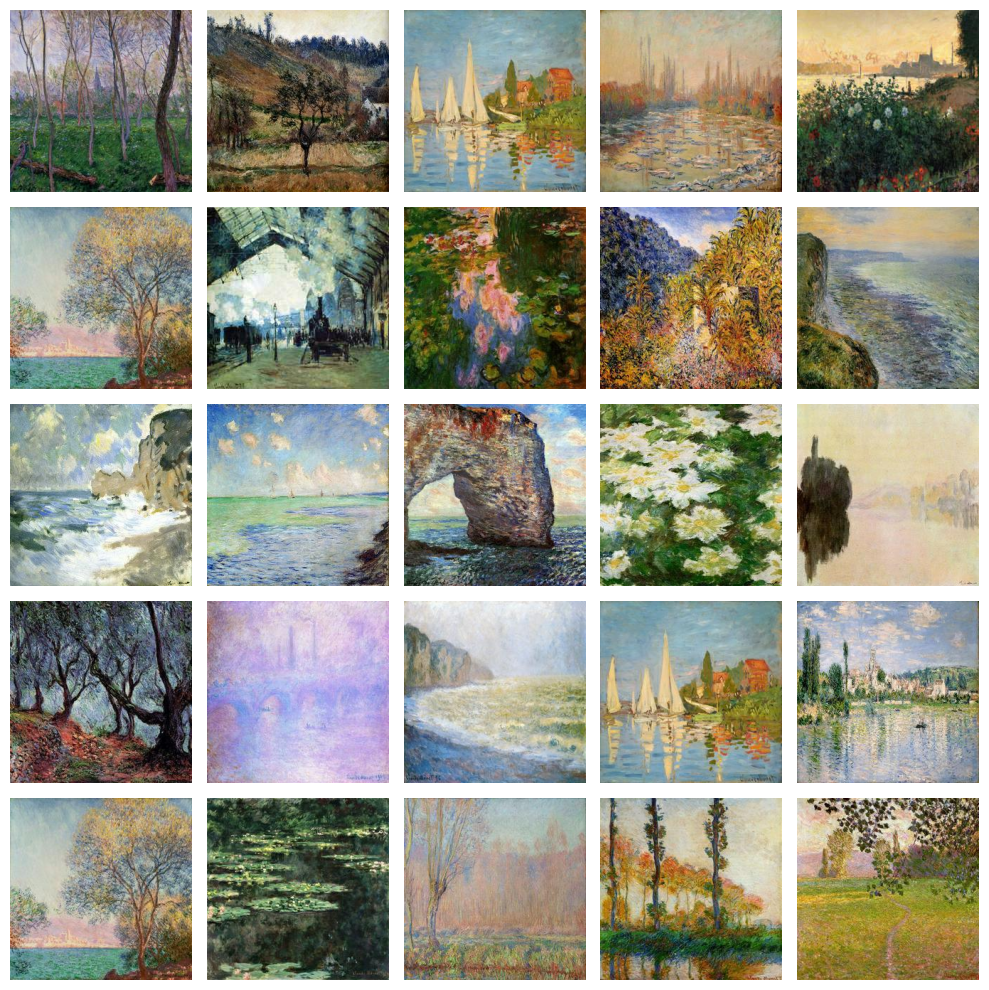

In [2]:
import math
import random


def plot_images(n: int) -> None:
    """
    I spent more time on this than I should have...
    But the render is worth it.
    """
    selected_images = random.choices(IMG_FILES, k=n)
    cols = round(math.sqrt(n))
    rows = n // cols
    rows += n % cols

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    axes = axes.ravel()

    for idx, img in enumerate(selected_images):
        img_path = os.path.join(IMG_DIR, img)
        image = mpimg.imread(img_path)
        axes[idx].imshow(image)
        axes[idx].axis('off')

    # These are unused subplots.
    for idx in range(n, rows * cols):
        fig.delaxes(axes[idx])
    plt.tight_layout()
    save_plot("monet-mosaic.png")
    plt.show()


plot_images(25)

## EDA - Shape, Colors, and Complexity

The idea of trying to capture the essentials of Monet's work with EDA is distasteful. Nevertheless, we persist.

Here we'll attempt to show the following: 

1. Image Size and Aspect Ratio: Check the sizes and aspect ratios of the images in the dataset. The output images should be 256x256x3, so understanding the original image dimensions can help us better preprocess the images for the GAN. For instance, if most images are of a certain aspect ratio, we might want to resize or crop the images in a way that maintains that ratio before feeding them into the GAN.
2. Image Distribution: Analyze the color distribution of the images in the dataset. This can be done by plotting histograms of the color channels (Red, Green, Blue). This will give us an understanding of the color palette used by Monet and will be useful when generating new images.
3. Image Complexity: Evaluate the complexity of the images in terms of the variety of shapes, lines, and textures present. This can be done by applying edge detection or texture analysis techniques. Understanding the complexity can help us tune the GAN to generate images with similar complexity.

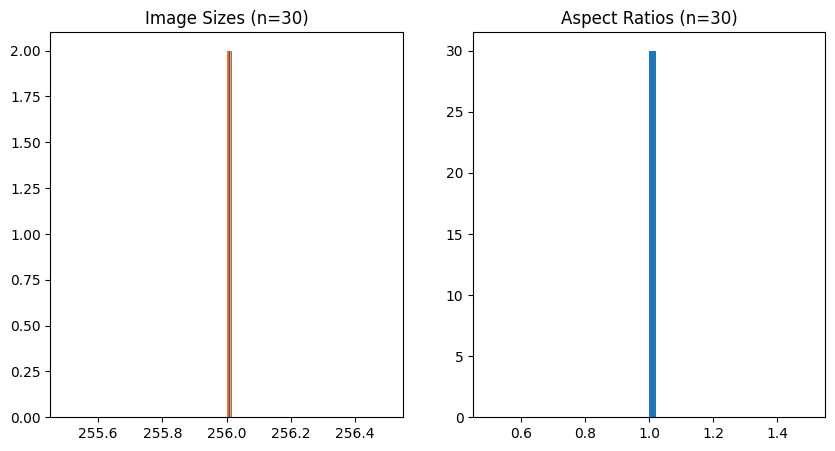

All square, 256x256 images.


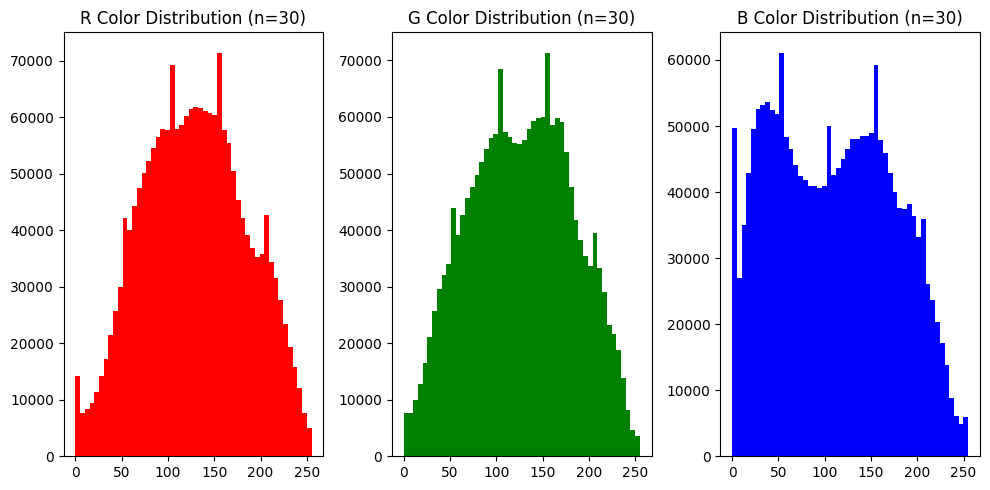

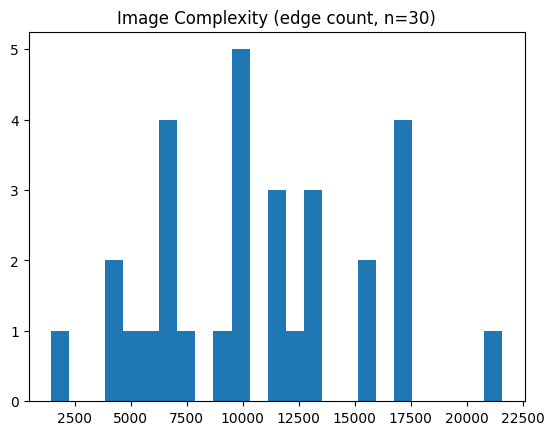

In [3]:
import cv2
import numpy as np

IMAGE_SAMPLES = random.sample(IMG_FILES, k=30)


def plot_img_sizes_and_aspect() -> None:
    sizes = []
    aspect_ratios = []
    for img_file in IMAGE_SAMPLES:
        img = mpimg.imread(os.path.join(IMG_DIR, img_file))
        h, w, _ = img.shape
        sizes.append((h, w))
        aspect_ratios.append(h / w)
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.hist(sizes, bins=50)
    plt.title(f'Image Sizes (n={len(IMAGE_SAMPLES)})')
    plt.subplot(122)
    plt.hist(aspect_ratios, bins=50)
    plt.title(f'Aspect Ratios (n={len(IMAGE_SAMPLES)})')
    save_plot("eda-1-img-size.png")
    plt.show()
    print("All square, 256x256 images.")


def plot_color_distribution() -> None:
    color_distribution = {'r': [], 'g': [], 'b': []}
    for img_file in IMAGE_SAMPLES:
        img = mpimg.imread(os.path.join(IMG_DIR, img_file))
        for i, color in enumerate(['r', 'g', 'b']):
            color_distribution[color].extend(img[:, :, i].flatten())
    plt.figure(figsize=(10, 5))
    for i, color in enumerate(['r', 'g', 'b']):
        plt.subplot(1, 3, i + 1)
        plt.hist(color_distribution[color], bins=50, color=color)
        plt.title(f'{color.upper()} Color Distribution (n={len(IMAGE_SAMPLES)})')
    plt.tight_layout()
    save_plot("eda-2-color-dist.png")
    plt.show()


def plot_image_complexity() -> None:
    complexities = []
    for img_file in IMAGE_SAMPLES:
        img = cv2.imread(os.path.join(IMG_DIR, img_file), cv2.IMREAD_GRAYSCALE)
        edges = cv2.Canny(img, 100, 200)  # Edge detection.
        complexity = np.sum(edges != 0)  # Count number of edges.
        complexities.append(complexity)
    plt.hist(complexities, bins=25)
    plt.title(f'Image Complexity (edge count, n={len(IMAGE_SAMPLES)})')
    save_plot("eda-3-complexity.png")
    plt.show()


plot_img_sizes_and_aspect()
plot_color_distribution()
plot_image_complexity()


## Data Preparation

We don't need much preparation, since images are already in the expected output format. There are some things we can do before creating and training a model, though.

* Normalization - Neural networks usually perform better when input data is in the range of [-1, 1] or [0, 1]. This is because smaller input values help prevent the network's weights from becoming too large, which can lead to unstable training. For our GAN, we'll normalize the images to get inputs into the [0, 1] range instead of the 0-255 range of RGB. We'll do this by dividing each pixel value by 255.
* Train/Test Split - GANs usually don't need a separate test set, because the goal of a GAN is to learn to generate new data that's similar to the training data (ie: not making predictions). Even so, it can be useful to hold out some images as a reference for the style we're trying to get. We'll set aside a small portion of the images for this. UPDATE: we won't.
* Batching - Training GANs usually involves using mini-batch gradient descent (hello Week 3). This means that instead of updating the model's weights based on the entire dataset at once, we update them based on a small batch of images. This helps make the training process more manageable and can also lead to better results, as the noise introduced by the mini-batches can help prevent the model from getting stuck in poor solutions. We can use ImageDataGenerator in Keras w/ TensorFlow backend.

In [4]:
import keras
import tensorflow as tf

RANDOM_STATE = 35
BATCH_SIZE = 16


def normalize_img(image) -> tf.Tensor:
    """
    Normalizes images: `uint8` -> `float32`.
    """
    return tf.cast(image, tf.float32) / 255.


def batch(batch_size: int, tiny=False) -> tf.data.Dataset:
    """
    Create batches of images and normalize.
    """
    if tiny:
        dataset = keras.preprocessing.image_dataset_from_directory(
        IMG_DIR,
        labels=None,  # GAN!
        batch_size=batch_size,
        image_size=(256, 256),
        shuffle=True,
        seed=RANDOM_STATE,
        validation_split=0.948,
        subset="training",
    )
        return dataset.map(normalize_img)
    dataset = keras.preprocessing.image_dataset_from_directory(
        IMG_DIR,
        labels=None,  # GAN!
        batch_size=batch_size,
        image_size=(256, 256),
        shuffle=True,
        seed=RANDOM_STATE,
    )
    return dataset.map(normalize_img)

dataset = batch(BATCH_SIZE, True)

2024-06-15 16:03:43.332418: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 16:03:43.360195: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 16:03:43.810540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 300 files.
Using 16 files for training.


2024-06-15 16:03:44.365136: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-15 16:03:44.462399: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Analysis, Architecture, and Tuning

Based on our EDA, the images are already 256x256x3, and they exhibit varied complexity and compact RGB channel distributions. Given these characteristics, the Deep Convolutional Generative Adversarial Network (DCGAN) is a good choice for us. Per [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they are known for their ability to handle complex patterns and color distributions, making them a good fit for the Monet image data.

I chose DCGAN over other popular architectures because of its proven performance for complex image generation. DCGANs are particularly good at capturing intricate patterns and details. Even though Monet is known for his impressionist style, there is still incredible detail in mimicing the brushstrokes and textures (see the 5x5 grid above). Other architectures like WGAN or CycleGAN could also be considered, but DCGAN's simplicity and efficiency make it a good default choice for me.

The hyperparameters! We can tune the generator and the discriminator, and we're going to leverage Keras. It has a HyperModel class that's very helpful here (I used optuna for prior projects). There are some changes we have to make though, because we're training in two steps.

You can see the tuning in the model architecture below - `alpha`, `conv_size`, `learning_rate` and `beta_1` are in there.

In [5]:
from keras import ops
from keras import Input, Model
from keras.src.layers import Dense, LeakyReLU, Conv2DTranspose, Reshape, Conv2D, Flatten, BatchNormalization
from keras.src.models import Sequential
from keras.src.optimizers import Adam


class DCGAN(Model):
    def __init__(self, latent_dim, params):
        super().__init__()
        self.latent_dim = latent_dim
        self.params = params
        
        self.d_optimizer = Adam(
            learning_rate=self.params["learning_rate_dis"],
            beta_1=self.params["beta_1_dis"])

        self.g_optimizer = Adam(
            learning_rate=self.params["learning_rate_gen"],
            beta_1=self.params["beta_1_gen"])
        
        self.loss_fn = keras.losses.BinaryCrossentropy()
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=self.loss_fn, optimizer=self.d_optimizer, metrics=['accuracy'])
        self.generator = self.build_generator()
        self.generator.compile(loss=self.loss_fn, optimizer=self.g_optimizer, metrics=['accuracy'])
        self.seed_generator = keras.random.SeedGenerator(RANDOM_STATE)

    def build_discriminator(self) -> Sequential:
        discriminator = Sequential()
        discriminator.add(Input((256, 256, 3)))
        discriminator.add(
            Conv2D(128, kernel_size=self.params["conv_size_dis"], strides=(2, 2), padding='same'))
        discriminator.add(
            LeakyReLU(negative_slope=self.params["leaky_alpha_dis"]))
        discriminator.add(
            Conv2D(128, kernel_size=self.params["conv_size_gen"], strides=(2, 2), padding='same'))
        discriminator.add(
            LeakyReLU(negative_slope=self.params["leaky_alpha_dis"]))
        discriminator.add(Flatten())
        discriminator.add(Dense(1, activation='sigmoid'))
        self.discriminator = discriminator
        return discriminator

    def build_generator(self) -> Sequential:
        generator = Sequential()
        n_nodes = 128 * 64 * 64
        generator.add(Input((self.latent_dim,)))
        generator.add(Dense(n_nodes))
        generator.add(LeakyReLU(negative_slope=self.params["leaky_alpha_gen"]))
        generator.add(Reshape((64, 64, 128)))
        generator.add(Conv2DTranspose(128, kernel_size=self.params["conv_size_gen"], strides=(2, 2),
                                      padding='same'))
        generator.add(LeakyReLU(negative_slope=self.params["leaky_alpha_gen"]))
        generator.add(Conv2DTranspose(128, kernel_size=self.params["conv_size_gen"], strides=(2, 2),
                                      padding='same'))
        generator.add(LeakyReLU(negative_slope=self.params["leaky_alpha_gen"]))
        generator.add(Conv2D(3, (7, 7), activation='tanh', padding='same'))
        assert generator.output_shape == (None, 256, 256, 3), f"got output shape of {generator.output_shape}"
        self.generator = generator
        return generator

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(shape=(batch_size, self.latent_dim), seed=self.seed_generator)

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(shape=(batch_size, self.latent_dim), seed=self.seed_generator)

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    
    def call(self, images):
        predictions = self.discriminator(images, training=False)
        return predictions


class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=1, latent_dim=128):
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(RANDOM_STATE)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(os.path.join(ARTIFACT_DIR, "generated", "generated_img_%03d_%d.png" % (epoch, i)))

## Training, Results, and Discussion

In [6]:
import optuna
import tensorflow as tf

def objective(trial):
    params = {
        "learning_rate_dis": trial.suggest_float("learning_rate_dis", 1e-5, 1e-2, log=True),
        "beta_1_dis": trial.suggest_float("beta_1_dis", 0.0, 0.9),
        "learning_rate_gen": trial.suggest_float("learning_rate_gen", 1e-5, 1e-2, log=True),
        "beta_1_gen": trial.suggest_float("beta_1_gen", 0.0, 0.9),
        "conv_size_dis": trial.suggest_categorical("conv_size_dis", [3, 5, 7]),
        "leaky_alpha_dis": trial.suggest_float("leaky_alpha_dis", 0.0, 0.3),
        "conv_size_gen": trial.suggest_categorical("conv_size_gen", [3, 5, 7]),
        "leaky_alpha_gen": trial.suggest_float("leaky_alpha_gen", 0.0, 0.3),
    }

    latent_dim = 128
    dcgan = DCGAN(latent_dim, params)
    dcgan.compile(loss=keras.losses.BinaryCrossentropy())
    # dcgan.fit(dataset, epochs=1, callbacks=[GANMonitor(latent_dim=latent_dim)])
    dcgan.fit(dataset, epochs=2, callbacks=[])

    # Combine generator and discriminator losses.
    total_loss = dcgan.g_loss_metric.result() + dcgan.d_loss_metric.result()
    
    return total_loss.numpy()

# Quiet down, TF.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
tf.get_logger().setLevel('ERROR')

# Optimize.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
study.best_params

[I 2024-06-15 16:03:44,585] A new study created in memory with name: no-name-15feaa57-4f7b-48b6-b9ee-e21f11052122


Epoch 1/2


2024-06-15 16:03:45.828892: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/sequential_2/leaky_re_lu_1_2/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/sequential_2/conv2d_1_2/add'.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - d_loss: 0.6890 - g_loss: 0.0603
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - d_loss: 23.7435 - g_loss: 59.4076


[I 2024-06-15 16:03:56,083] Trial 0 finished with value: 83.15104675292969 and parameters: {'learning_rate_dis': 0.003771206571040144, 'beta_1_dis': 0.6675734716877741, 'learning_rate_gen': 0.0015679409397071039, 'beta_1_gen': 0.06224889998493371, 'conv_size_dis': 3, 'leaky_alpha_dis': 0.17958536110991682, 'conv_size_gen': 5, 'leaky_alpha_gen': 0.07385655604752862}. Best is trial 0 with value: 83.15104675292969.


Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - d_loss: 0.7183 - g_loss: 0.2680
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - d_loss: 5.0665 - g_loss: 175.4097


[I 2024-06-15 16:04:12,890] Trial 1 finished with value: 180.4761505126953 and parameters: {'learning_rate_dis': 0.00344261879067682, 'beta_1_dis': 0.3052287778727708, 'learning_rate_gen': 0.00066198681967342, 'beta_1_gen': 0.7586178983595183, 'conv_size_dis': 5, 'leaky_alpha_dis': 0.2515085743707713, 'conv_size_gen': 7, 'leaky_alpha_gen': 0.09709730484186958}. Best is trial 0 with value: 83.15104675292969.


Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - d_loss: 0.7059 - g_loss: 0.6880
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - d_loss: 0.4125 - g_loss: 0.7717


[I 2024-06-15 16:04:26,432] Trial 2 finished with value: 1.1841762065887451 and parameters: {'learning_rate_dis': 0.00046899565606316673, 'beta_1_dis': 0.6062450535420892, 'learning_rate_gen': 2.1369412553075728e-05, 'beta_1_gen': 0.22374882309063646, 'conv_size_dis': 5, 'leaky_alpha_dis': 0.0714688135799443, 'conv_size_gen': 5, 'leaky_alpha_gen': 0.1785872145797767}. Best is trial 2 with value: 1.1841762065887451.


Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - d_loss: 0.6821 - g_loss: 0.4035
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - d_loss: 6.2104 - g_loss: 18.8902


[I 2024-06-15 16:04:34,633] Trial 3 finished with value: 25.100631713867188 and parameters: {'learning_rate_dis': 0.0036557736803420984, 'beta_1_dis': 0.8039279777473947, 'learning_rate_gen': 0.000962746545336218, 'beta_1_gen': 0.35475821605772045, 'conv_size_dis': 5, 'leaky_alpha_dis': 0.25570106723839725, 'conv_size_gen': 3, 'leaky_alpha_gen': 0.0026096506383973647}. Best is trial 2 with value: 1.1841762065887451.


Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - d_loss: 0.7029 - g_loss: 0.6370
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - d_loss: 4.8313 - g_loss: 27.7451


[I 2024-06-15 16:04:54,953] Trial 4 finished with value: 32.57637405395508 and parameters: {'learning_rate_dis': 0.0007242476234587076, 'beta_1_dis': 0.3550706503309165, 'learning_rate_gen': 0.0014972944518792993, 'beta_1_gen': 0.8521724056540805, 'conv_size_dis': 7, 'leaky_alpha_dis': 0.2694765376202316, 'conv_size_gen': 7, 'leaky_alpha_gen': 0.19802439603368938}. Best is trial 2 with value: 1.1841762065887451.


Epoch 1/2


2024-06-15 16:04:56.272140: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/sequential_10_1/leaky_re_lu_26_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/sequential_10_1/conv2d_16_1/add'.


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - d_loss: 0.7197 - g_loss: 0.6650
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - d_loss: 0.4658 - g_loss: 0.7353


[I 2024-06-15 16:05:14,736] Trial 5 finished with value: 1.2010328769683838 and parameters: {'learning_rate_dis': 0.000411717578597465, 'beta_1_dis': 0.6446163907651699, 'learning_rate_gen': 1.8914094245927684e-05, 'beta_1_gen': 0.7926275075030926, 'conv_size_dis': 5, 'leaky_alpha_dis': 0.20456782941356624, 'conv_size_gen': 7, 'leaky_alpha_gen': 0.05105255217414569}. Best is trial 2 with value: 1.1841762065887451.


Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - d_loss: 0.6620 - g_loss: 0.6928
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - d_loss: 0.4260 - g_loss: 0.6942


[I 2024-06-15 16:05:27,372] Trial 6 finished with value: 1.1201262474060059 and parameters: {'learning_rate_dis': 8.77393267710728e-05, 'beta_1_dis': 0.44869613573377, 'learning_rate_gen': 2.3281774543387347e-05, 'beta_1_gen': 0.6795554120683278, 'conv_size_dis': 5, 'leaky_alpha_dis': 0.2724893969039083, 'conv_size_gen': 5, 'leaky_alpha_gen': 0.25072113199599216}. Best is trial 6 with value: 1.1201262474060059.


Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - d_loss: 0.7326 - g_loss: 0.6170
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - d_loss: 19.1941 - g_loss: 37.6914


[I 2024-06-15 16:05:41,638] Trial 7 finished with value: 56.885475158691406 and parameters: {'learning_rate_dis': 0.0010360683637422527, 'beta_1_dis': 0.4940280356999713, 'learning_rate_gen': 0.003149777521375187, 'beta_1_gen': 0.6841586339252738, 'conv_size_dis': 7, 'leaky_alpha_dis': 0.19540609998846628, 'conv_size_gen': 5, 'leaky_alpha_gen': 0.14924841088992083}. Best is trial 6 with value: 1.1201262474060059.


Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - d_loss: 0.6990 - g_loss: 0.5713
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - d_loss: 46.8167 - g_loss: 66.2499


[I 2024-06-15 16:05:55,670] Trial 8 finished with value: 113.0665512084961 and parameters: {'learning_rate_dis': 0.0014618473439923603, 'beta_1_dis': 0.4369509784371965, 'learning_rate_gen': 0.004729848108480295, 'beta_1_gen': 0.08232836449307261, 'conv_size_dis': 5, 'leaky_alpha_dis': 0.012019306627202464, 'conv_size_gen': 5, 'leaky_alpha_gen': 0.11707959651127525}. Best is trial 6 with value: 1.1201262474060059.


Epoch 1/2


2024-06-15 16:05:57.271829: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/sequential_18_1/leaky_re_lu_46_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/sequential_18_1/conv2d_28_1/add'.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - d_loss: 0.6877 - g_loss: 0.3887
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - d_loss: 55.1384 - g_loss: 28.9600


[I 2024-06-15 16:06:04,798] Trial 9 finished with value: 84.09845733642578 and parameters: {'learning_rate_dis': 0.0024861547972351112, 'beta_1_dis': 0.622413847304388, 'learning_rate_gen': 0.005920519308780413, 'beta_1_gen': 0.5515431499315369, 'conv_size_dis': 7, 'leaky_alpha_dis': 0.01780439329005439, 'conv_size_gen': 3, 'leaky_alpha_gen': 0.11126694878417244}. Best is trial 6 with value: 1.1201262474060059.


{'learning_rate_dis': 8.77393267710728e-05,
 'beta_1_dis': 0.44869613573377,
 'learning_rate_gen': 2.3281774543387347e-05,
 'beta_1_gen': 0.6795554120683278,
 'conv_size_dis': 5,
 'leaky_alpha_dis': 0.2724893969039083,
 'conv_size_gen': 5,
 'leaky_alpha_gen': 0.25072113199599216}

In [7]:
# Get a bigger dataset.
dataset = batch(BATCH_SIZE)
# Actually train longer - let's see how we do.
latent_dim = 128
dcgan = DCGAN(latent_dim, study.best_params)
dcgan.compile(loss=keras.losses.BinaryCrossentropy())
dcgan.fit(dataset, epochs=20, callbacks=[GANMonitor(latent_dim=latent_dim)])

Found 300 files.
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - d_loss: 0.4563 - g_loss: 0.7377
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - d_loss: 0.1465 - g_loss: 2.3886
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 110s 6s/step - d_loss: 0.1423 - g_loss: 3.9236
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 112s 6s/step - d_loss: 1.0712 - g_loss: 0.8708
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 110s 6s/step - d_loss: 0.2685 - g_loss: 1.6618
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 116s 6s/step - d_loss: 0.4563 - g_loss: 1.8551
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 116s 6s/step - d_loss: 0.5001 - g_loss: 2.1906
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 127s 7s/step - d_loss: 0.1735 - g_loss: 3.0039
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 116s 6s/step - d_loss: 0.2134 - g_loss: 2.4173
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - d_loss: 0.4250 - g_loss: 3.2180
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 154s 8s/step - d_loss: 0.1561 - g_loss: 2.6794
Epoch 12/20
12/19 ━━━━━━━━━━━━━━━━━━━━ 55s 8s/


KeyboardInterrupt



In [8]:
print("DISCRIMINATOR")
dcgan.discriminator.summary()

DISCRIMINATOR


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 64, 64, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │       524,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,831,237 (10.80 MB)

 Trainable params: 943,745 (3.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,887,492 (7.20 MB)

In [9]:
print("GENERATOR")
dcgan.generator.summary()

GENERATOR


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 524288)         │    67,633,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_52 (LeakyReLU)      │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_20             │ (None, 128, 128, 128)  │       409,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_53 (LeakyReLU)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_21             │ (None, 256, 256, 128)  │       409,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_54 (LeakyReLU)      │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 256, 256, 3)    │        18,819 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,414,283 (783.59 MB)

 Trainable params: 68,471,427 (261.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 136,942,856 (522.40 MB)

## Generate files for Kaggle

In [11]:
import zipfile
from keras.src.utils import array_to_img
from IPython.display import clear_output

def generate_images(n, model):
    zip_filename = os.path.join(ARTIFACT_DIR, "generated", "images.zip")
    latent_dim = model.latent_dim

    # Ensure the directory for the generated zip file exists...
    os.makedirs(os.path.dirname(zip_filename), exist_ok=True)
    
    total_generated = 0
    batch_size = 25

    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        while total_generated < n:
            batch_count = min(batch_size, n - total_generated)
            random_latent_vectors = np.random.normal(size=(batch_count, latent_dim))
            generated_images = model.generator(random_latent_vectors)
            generated_images = (generated_images * 127.5 + 127.5).numpy().astype(np.uint8)

            for i in range(batch_count):
                img = array_to_img(generated_images[i])
                img_filename = f"img_{total_generated + i}.png"
                img_path = os.path.join(ARTIFACT_DIR, "temp_generated", img_filename)

                # Save image temporarily.
                os.makedirs(os.path.dirname(img_path), exist_ok=True)
                img.save(img_path)
                
                # Write to zip file.
                zipf.write(img_path, img_filename)

                # Remove temporary file.
                os.remove(img_path)

            total_generated += batch_count
            clear_output()
            print(f"Generated another batch of {batch_count}. Total generated: {total_generated}")

    # Remove temporary directory if empty
    temp_dir = os.path.join(ARTIFACT_DIR, "temp_generated")
    if os.path.exists(temp_dir) and not os.listdir(temp_dir):
        os.rmdir(temp_dir)

    return zip_filename

generate_images(7500, dcgan)

Generated another batch of 25. Total generated: 7500


'./artifact/generated/images.zip'

## Future Work and Summary

In the end, I decided on a DCGAN architecture, and did a fast search across the hyperparameter space. I don't have CUDA... :-(

My images don't look very much like Monet's, and that's okay.

Next time I can train for a much longer time.

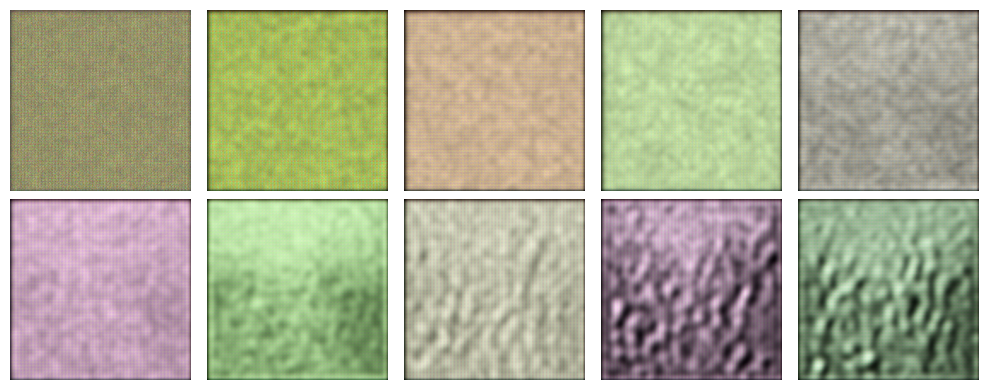

In [12]:
def show_generated_images():
    generated_dir = os.path.join(ARTIFACT_DIR, "generated")
    image_filenames = sorted([f for f in os.listdir(generated_dir) if f.endswith('.png')])
    
    num_images = len(image_filenames)
    cols = 5
    rows = (num_images + cols - 1) // cols  # Ceiling division to determine the number of rows.

    fig, axes = plt.subplots(rows, cols, figsize=(10, 2 * rows))
    
    for idx, filename in enumerate(image_filenames):
        img_path = os.path.join(generated_dir, filename)
        img = mpimg.imread(img_path)
        row = idx // cols
        col = idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.imshow(img)
        ax.axis('off')

    # Hide any remaining empty subplots.
    for idx in range(num_images, rows * cols):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout()
    save_plot("monet-mosaic-generated.png")
    plt.show()

show_generated_images()